# Simulator demo

In [1]:
import sys
sys.version_info

sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)

In [20]:
from common import Config, State, generate_pyplot_animation
from control import BalanceLQRControl, Trajectory, TrajectoryLQRControl
from simulator import CartPoleSimulator

import matplotlib.pyplot as plt
import numpy as np

from math import sin, cos
from IPython.display import HTML

In [3]:
config = Config()

init = State.home()
trajectory = Trajectory(config, init)

balance_control = BalanceLQRControl(config)
trajectory_control = TrajectoryLQRControl(config, trajectory)

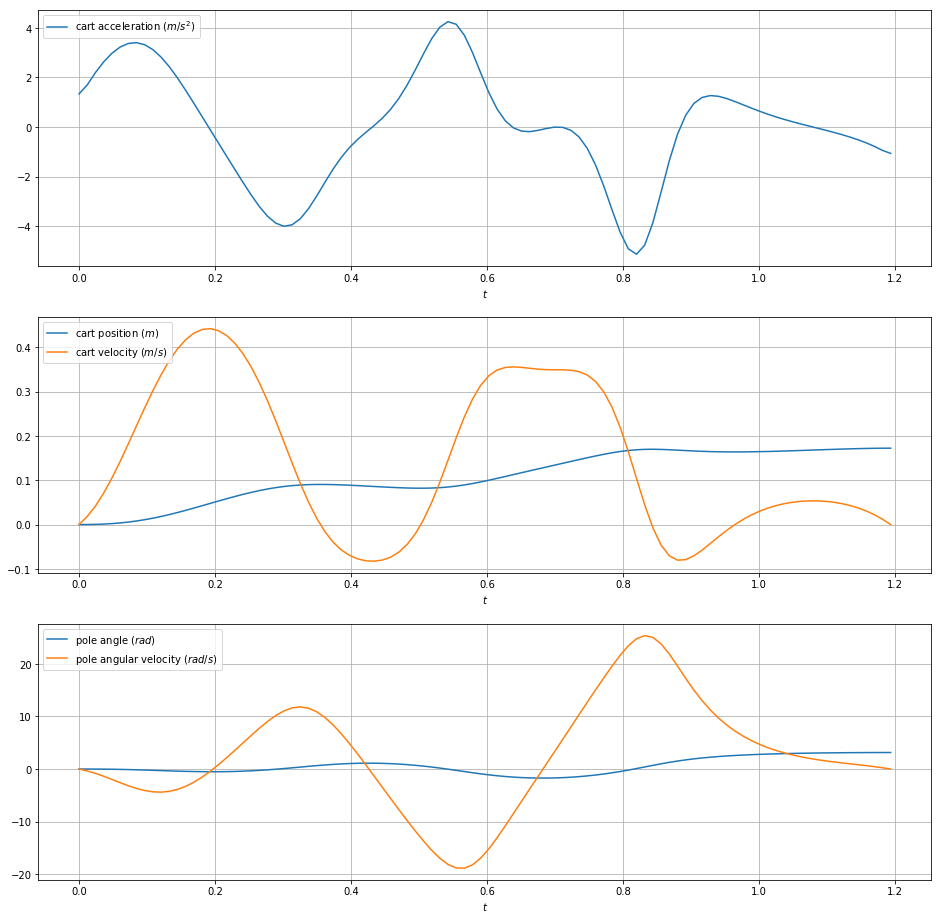

In [4]:
stamps, states, targets = trajectory.sample(100)
fig, ax = plt.subplots(3, 1, figsize=(16, 16))
    
ax[0].plot(stamps, targets, label=r'cart acceleration ($m/s^2$)')

ax[1].plot(stamps, states[:, 0], label='cart position ($m$)')
ax[1].plot(stamps, states[:, 2], label='cart velocity ($m/s$)')

ax[2].plot(stamps, states[:, 1], label=r'pole angle ($rad$)')
ax[2].plot(stamps, states[:, 3], label=r'pole angular velocity ($rad/s$)')

for i in range(3):
    ax[i].legend(loc='upper left')
    ax[i].set_xlabel(r'$t$')
    ax[i].grid()

In [11]:
cart_pole = CartPoleSimulator()
cart_pole.reset(config)

timestamps, states, targets = [], [], []
states_expected, targets_expected = [], []
start = cart_pole.timestamp()

for _ in range(150):
    state = cart_pole.get_state()
    stamp = cart_pole.timestamp() - start
    
    if stamp < trajectory.duration:
        target = trajectory_control(stamp, state)
    else:
        target = balance_control(state)
    
    cart_pole.set_target(target)
    cart_pole.advance(0.01)
    
    timestamps.append(stamp)
    states.append(state)
    targets.append(target)
    
    state_expected, target_expected = trajectory(stamp)
    
    states_expected.append(state_expected)
    targets_expected.append(target_expected)

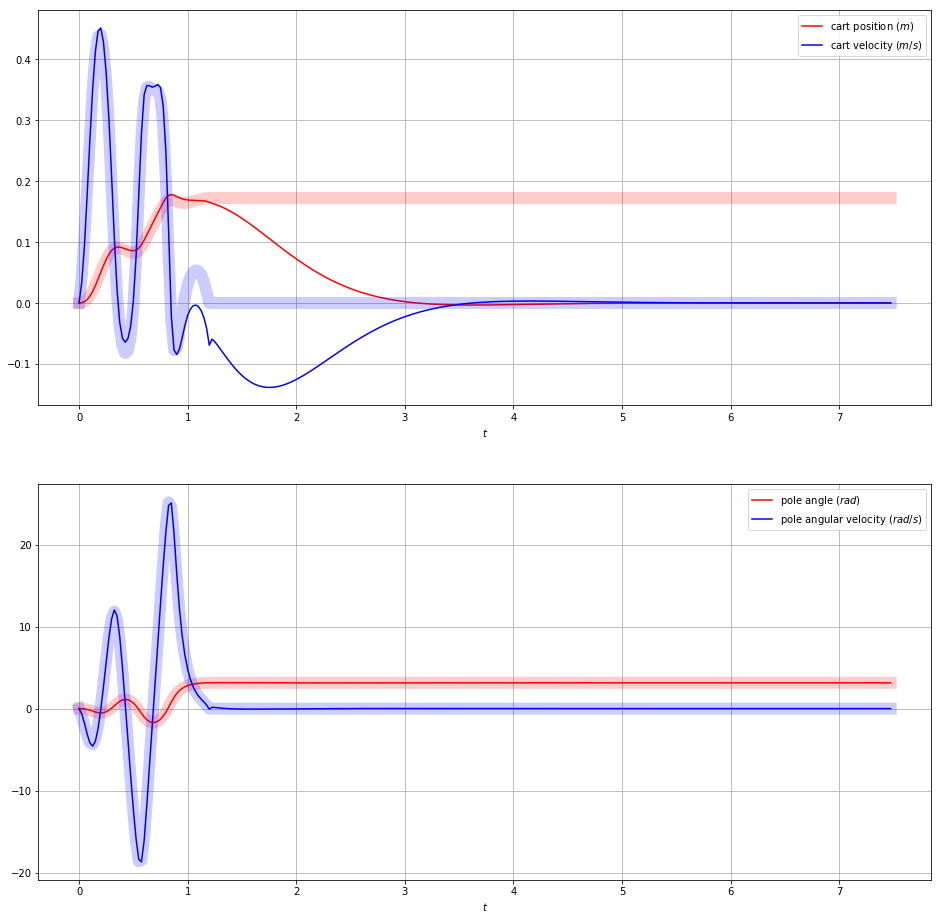

In [19]:
data = np.array([state.as_tuple() for state in states])

fig, ax = plt.subplots(2, 1, figsize=(16, 16))

x = [trajectory.states.value(t)[0] for t in timestamps]
v = [trajectory.states.value(t)[2] for t in timestamps]

ax[0].plot(timestamps, data[:, 0], c='r', label='cart position ($m$)')
ax[0].plot(timestamps, x, c='r', alpha=0.2, linewidth=12)

ax[0].plot(timestamps, data[:, 2], c='blue', label='cart velocity ($m/s$)')
ax[0].plot(timestamps, v, c='blue', alpha=0.2, linewidth=12)

a = [trajectory.states.value(t)[1] for t in timestamps]
w = [trajectory.states.value(t)[3] for t in timestamps]

ax[1].plot(timestamps, data[:, 1], c='r', label=r'pole angle ($rad$)')
ax[1].plot(timestamps, a, c='r', alpha=0.2, linewidth=12)

ax[1].plot(timestamps, data[:, 3], c='blue', label=r'pole angular velocity ($rad/s$)')
ax[1].plot(timestamps, w, c='blue', alpha=0.2, linewidth=12)

for i in range(2):
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel(r'$t$')
    ax[i].grid()

In [ ]:
anim = generate_pyplot_animation(config, states, states_expected, timestamps=timestamps)
HTML(anim.to_jshtml())